In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.pandas
import montecarlo as mc
import seaborn as sns
import panel as pn
from panel.interact import interact
import random
from iexfinance.stocks import get_historical_data
import iexfinance as iex


In [2]:
tickers_dict = {"index":["VOO"],
                "crypto":['BTC', 'ETH', 'XRP']}
years = 2
data_start_date = datetime.now() + timedelta(-365*years)

In [3]:
portfolio_hist_prices = mc.get_historic_data(ticker = tickers_dict["index"], 
                                             start_date = data_start_date)
#portfolio_hist_prices.head()

In [4]:
btc_daily_price = mc.get_crypto_daily_price(tickers_dict["crypto"],limit=years*365)
#btc_daily_price.head()

In [5]:
portfolio_hist_prices = pd.concat([portfolio_hist_prices,btc_daily_price],axis=1,join="inner")
portfolio_hist_prices.dropna(inplace=True)
portfolio_hist_prices = portfolio_hist_prices[(portfolio_hist_prices[portfolio_hist_prices.columns] != 0).all(axis=1)]
#portfolio_hist_prices.head()

In [6]:
portfolio_hist_prices = mc.normalize_dataframe(portfolio_hist_prices)
portfolio_daily_retn = portfolio_hist_prices.pct_change().copy()

#portfolio_daily_retn

In [7]:
def corr_plot(portfolio_daily_retn):
    
    title_font = {'family': 'monospace',
            'color':  'blue',
            'weight': 'bold',
            'size': 15,
            }
    correlated = portfolio_daily_retn.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(correlated, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set up the matplotlib figure
    correlated_plot, ax = plt.subplots(figsize=(6, 4))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlated, mask=mask, cmap="coolwarm", vmax=1, vmin =-1, center=0,
                square=True, linewidths=.5, annot=True
                #cbar_kws={"shrink": .5}
               )
    plt.title(f"Correlation Map of Portfolio\n",fontdict=title_font)
    ax.set_facecolor("aliceblue")
    
    #correlated_plot = sns.heatmap(correlated, vmin=-1, vmax=1, annot=True,cmap="coolwarm") 
    plt.close()
    return pn.Pane(correlated_plot)

In [8]:
def get_corr_pane(portfolio_daily_retn):
    header_text = pn.panel("<marquee> The latest news on crypto and finance here: BTC up 20,000.00% in last year, 7.77% today"+
                           " ETH up 400,000.00% in the last year, 9.99% today, "
                           +" Trump lost re-election due to poor results, Global peace achieved yesterday at UN, "
                           +" S&P500 down 10% in the last year, down 1.21%, today, "
                           +"cryptocurrencies are being used more than dollar for international trading, XRP up 27.89% today, "
                           +" Satoshi just gave away his millions of BTC to the most needed people in the developing world, "
                           +" military war on drugs has been replaced by an educational war "
                           +"on drugs and regulation of legal point of sales, drug cartels in bankruptcy, "
                           +" Colombians achieved peace for first time in more than 60 years...</marquee>", 
                           align = "center")

    side_text = pn.pane.Markdown(
            '''
# Side Text
## Some sub title

And here we go with the test: We are building the coolest dashboard on earth since 2020.
''',
        align= "center", max_width = 180)
    
    lower_text = pn.pane.Markdown('''
# Lower Text
## Some sub title

And here we go with the test: We are building the coolest dashboard on earth since 2020.
        ''',
                                  align= "start",
                                  width_policy = "max",
                                 )###??????????
    #WARNING:param.Markdown11741: Setting non-parameter attribute
    #max_with=5 using a mechanism intended only for parameters

    middle_row = pn.Row( side_text, corr_plot(portfolio_daily_retn), width_policy="fit")
    
    
    corr_pane = pn.Column(header_text,middle_row,lower_text,align="center")
    
    return corr_pane
    

Column(align='center')
    [0] Markdown(str, align='center')
    [1] Row(width_policy='fit')
        [0] Markdown(str, align='center', max_width=180)
        [1] Matplotlib(Figure)
    [2] Markdown(str, width_policy='max')
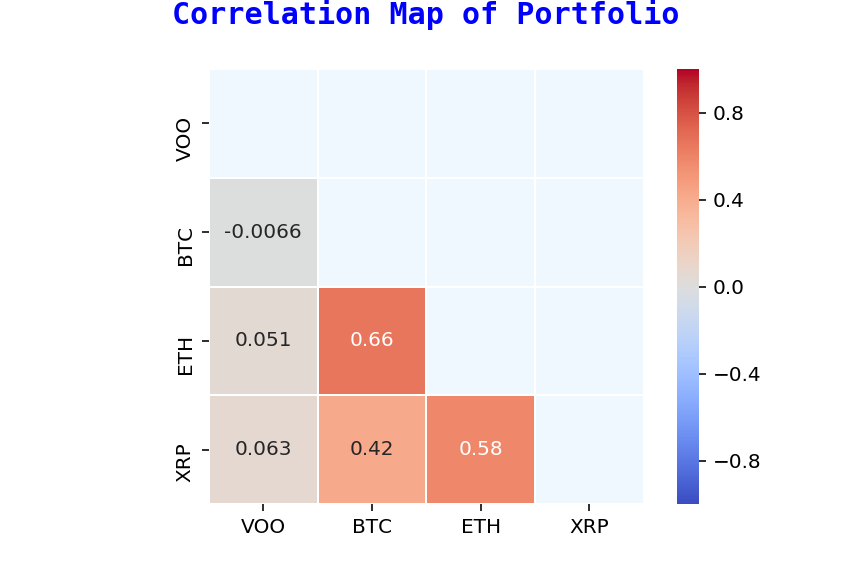

In [9]:
get_corr_pane(portfolio_daily_retn)

In [10]:
def sharp_rt_plot(portfolio_daily_retn):
    
    title_font = {'family': 'monospace',
            'color':  'blue',
            'weight': 'bold',
            'size': 15,
            }
    label_font = {'family': 'monospace',
            'color':  'green',
            'weight': 'bold',
            'size': 12,
            }
   # bar_colors=["orange","plum","yellowgreen","indigo","wheat","salmon","lightblue","purple","gold",
    #           "cornflowerblue","mediumslateblue","seagreen","peru"]
    bar_colors=["midnightblue","royalblue","indigo","darkcyan","darkgreen","maroon",
               "purple","darkorange","slategray","forestgreen"]

    sharp_ratios = portfolio_daily_retn.mean()*np.sqrt(252)/portfolio_daily_retn.std()
    
    sr_plot = plt.figure();
    plt.bar(x = sharp_ratios.index, height=sharp_ratios, color=random.sample(bar_colors,len(sharp_ratios.index)))
    plt.title(f"Sharp Ratios of Portfolio\n",fontdict=title_font)
    plt.ylabel("Sharp Ratio",fontdict=label_font)
    plt.xlabel("Assets",fontdict=label_font)
    plt.axhline(sharp_ratios.mean(), color='r')
    
    
    plt.close()
    return pn.Pane(sr_plot)

Matplotlib(Figure)
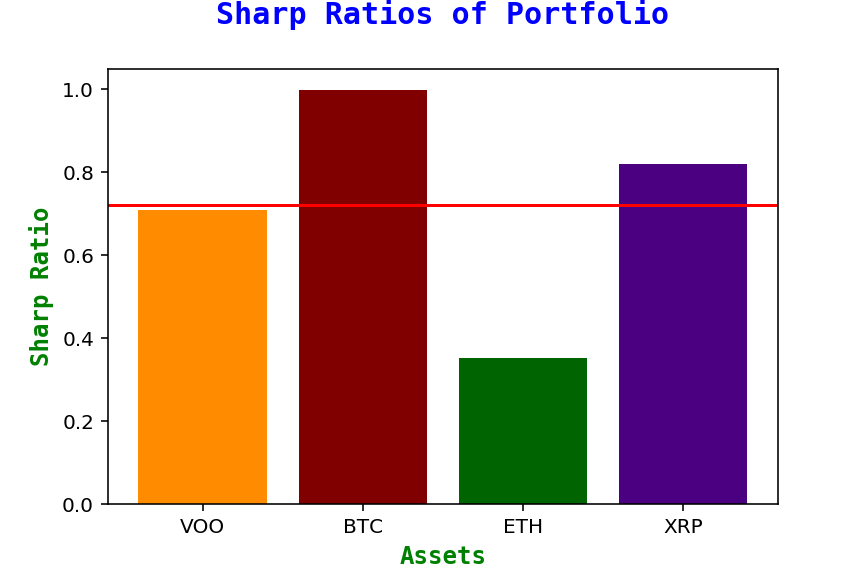

In [11]:
plot = sharp_rt_plot(portfolio_daily_retn)
plot

In [12]:


def plot_mont_carl(monte_carlo_sim):
    plot_title = f"Monte-Carlo Simulation of Portfolio"
    monte_carlo_sim_plot = monte_carlo_sim.hvplot(title=plot_title,figsize=(18,10),legend=False)
    return monte_carlo_sim_plot

In [13]:
def get_conf_interval(db,q=[0.05, 0.95]):
    confidence_interval = db.iloc[-1].quantile(q=q)
    return confidence_interval

In [14]:
def plot_conf(values=None,conf=[0,0]):
    bar_colors=["midnightblue","royalblue","indigo","black","darkcyan","darkgreen",
               "purple","darkorange","slategray"]
    conifidence_plot = plt.figure(figsize=(12,8));
    #plt.plot(values,kind='hist', density=True, bins=20)
    plt.hist(x = values,bins=20, color = random.choice(bar_colors))
    plt.axvline(conf.iloc[0], color='r')
    plt.axvline(conf.iloc[1], color='r')
    plt.close()
    return pn.Pane(conifidence_plot)

# DASHBOARD TIME!!!

In [15]:
#print(portfolio_hist_prices.head())

In [16]:
portfolio_hist_prices = portfolio_hist_prices[(portfolio_hist_prices[portfolio_hist_prices.columns] != 0).all(axis=1)]
#portfolio_hist_prices.any()
#portfolio_hist_prices.head()

In [17]:
mc_sim = mc.monte_carlo_sim(portfolio_hist_prices,trials = 50)

In [18]:
risk_tabs = pn.Tabs(
    ("Correlation of portfolio",get_corr_pane(portfolio_daily_retn)),
    ("Sharp Ratios", sharp_rt_plot(portfolio_daily_retn)),
    background="whitesmoke"
)

In [19]:
montecarlo_tabs = pn.Tabs(
    ("monte Carlo Simulation",plot_mont_carl(mc_sim)),
    ("Confidence Intervals", plot_conf(mc_sim.iloc[-1],get_conf_interval(mc_sim))),
    background="whitesmoke"
)

In [20]:
techl_analysis_tabs = pn.Tabs(
    ("TA1","in construction"),
    ("TA2", "in construction"),
    background="whitesmoke"
)

In [21]:
tabs = pn.Tabs(
    ("Risk",risk_tabs),
    ("Monte Carlo Simulation", montecarlo_tabs),
    ("Tecnical Analysis", techl_analysis_tabs),
    ("Report", "in construction"),
    tabs_location = "left",
    align = "start"
)
  

Tabs(tabs_location='left')
    [0] Tabs(background='whitesmoke')
        [0] Column(align='center')
            [0] Markdown(str, align='center')
            [1] Row(width_policy='fit')
                [0] Markdown(str, align='center', max_width=180)
                [1] Matplotlib(Figure)
            [2] Markdown(str, width_policy='max')
        [1] Matplotlib(Figure)
    [1] Tabs(background='whitesmoke')
        [0] HoloViews(NdOverlay, name='monte Carlo Simulation')
        [1] Matplotlib(Figure)
    [2] Tabs(background='whitesmoke')
        [0] Markdown(str, name='TA1')
        [1] Markdown(str, name='TA2')
    [3] Markdown(str, name='Report')
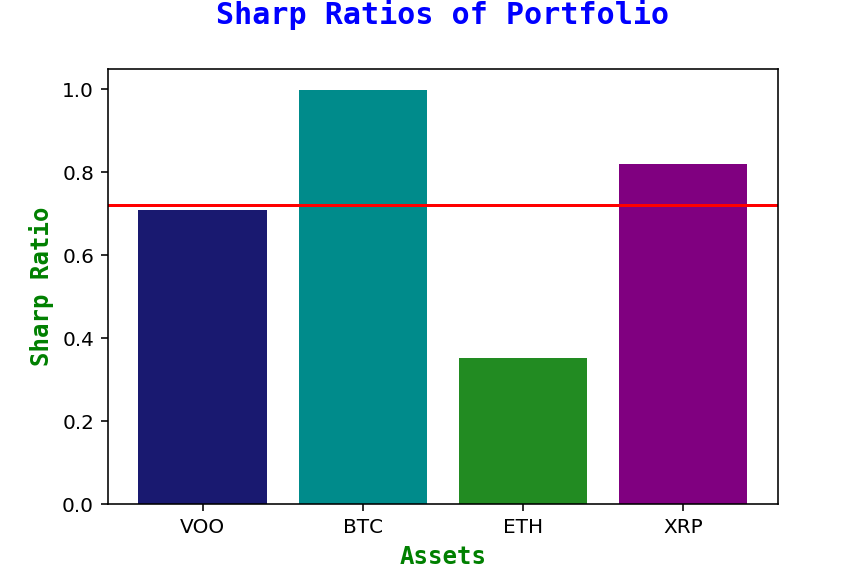
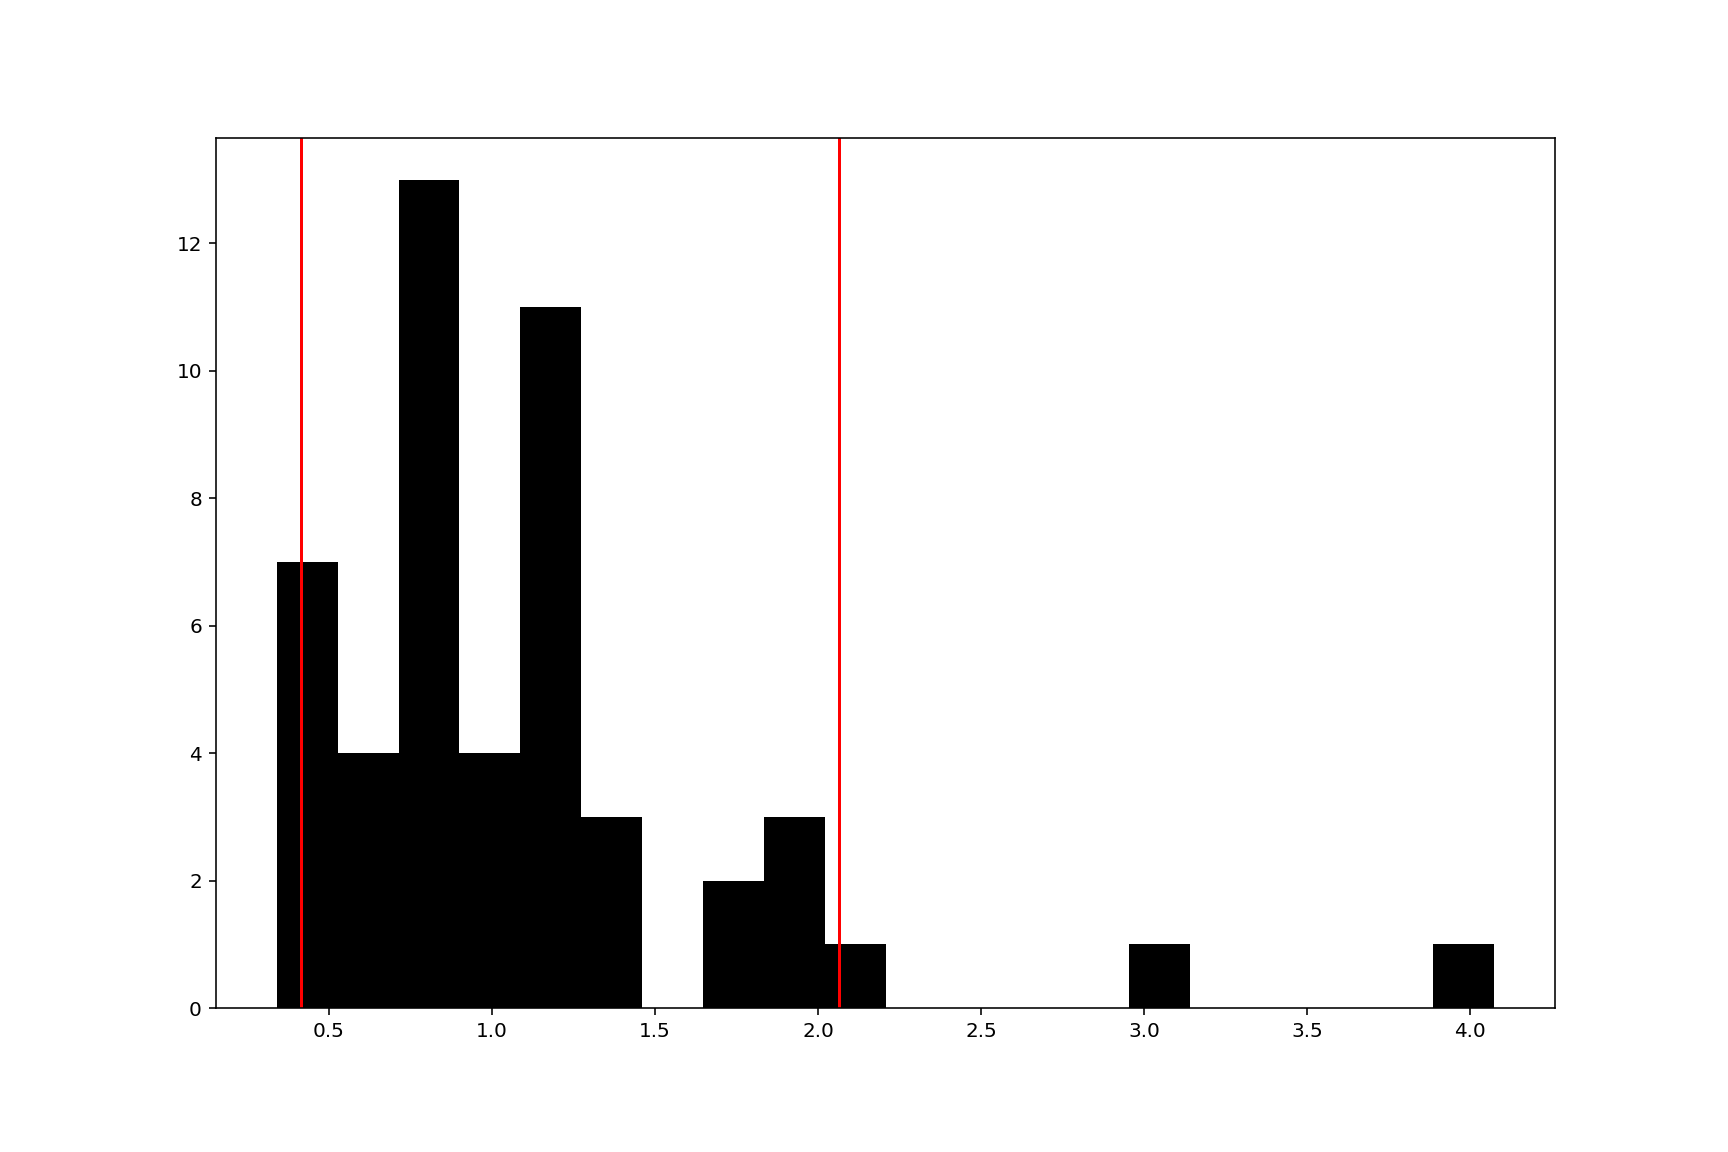
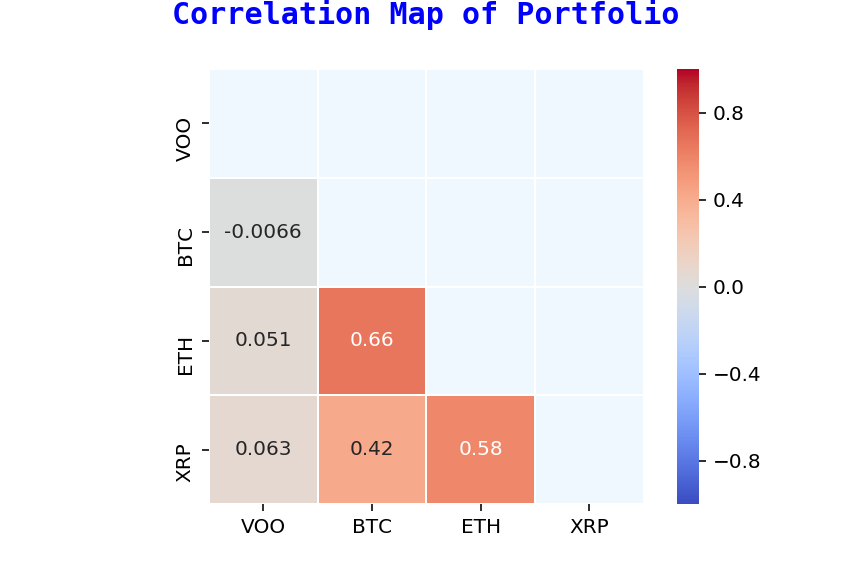

In [22]:
  
panel = tabs

panel